This Notebook needs https://github.com/mineo/mpd_pydb for reading MPDs database

In [1]:
%pylab inline
matplotlib.style.use("ggplot")
import mpd_pydb as mpd
from os.path import expanduser
db = mpd.Database.read_file(expanduser("~/.mpd/mpd.db"))
df = db.to_dataframe()

Populating the interactive namespace from numpy and matplotlib


In [2]:
df[["Album", "Artist", "AlbumArtist", "Title", "Date"]].describe()

,Album,Artist,AlbumArtist,Title,Date
count,18161,18217,18036,18217,17445
unique,1502,3843,707,16824,1004
top,A Traveler’s Guide to Space and Time,John Williams,Various Artists,Intro,2003
freq,168,311,2843,16,237


# Song length distribution

In [3]:
times = df["Time"]
times.describe()

count    18223.000000
mean       217.212172
std        121.652929
min          0.026000
25%        143.355000
50%        210.102000
75%        268.046500
max       3445.440000
Name: Time, dtype: float64

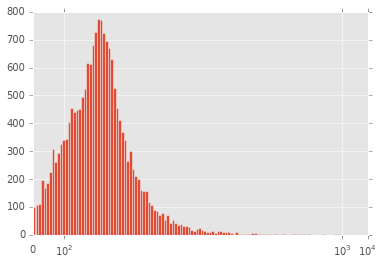

In [4]:
fig, ax = plt.subplots()
times.hist(ax=ax, bins=400)
ax.set_xscale("symlog", linthreshx=1000, linscalex=11)

Ok, there seem be some very long songs in the DB, let's ignore them for now. We're going to limit the song length to 600 seconds (10 minutes).

(0.0, 125)

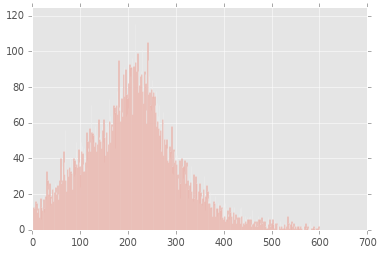

In [5]:
t = times[times <= 600]
fig, ax = plt.subplots()
t.hist(ax=ax, bins=600)
ax.set_ylim(top=125)

But let's also have a look at the songs longer than 600 seconds:

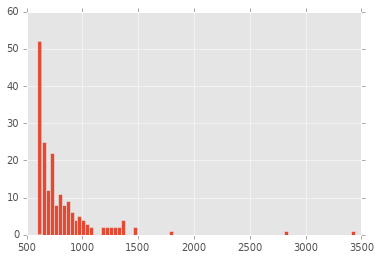

In [6]:
t = times[times > 600]
fig, ax = plt.subplots()
t.hist(ax=ax, bins=80)

# Duplicate tracks by recording id

In [7]:
trs = df[["MUSICBRAINZ_TRACKID", "Artist", "Title"]]
trs[trs.duplicated(subset=["MUSICBRAINZ_TRACKID"]) == True]

,MUSICBRAINZ_TRACKID,Artist,Title
1221,2e0c6163-211b-4527-a9f1-9f1738eb4673,Binärpilot,Tjaere Igjen
1223,da956ad1-0230-4c98-943e-2f965d0be86c,Binärpilot,I Met a Girl
1224,d9f6ca8b-d36b-4277-9111-5b77436193f8,Binärpilot,My Amore Lucile
1225,4731b669-2dee-424a-b075-556a05ec71c3,Binärpilot,Acrodysostosis
1227,611bf281-1314-418d-93ae-021bef8b3151,Binärpilot,Iritis
1228,19f9f259-1ea7-40de-926c-51a1bf077807,Binärpilot,Otosclerosis
1230,7dde8728-f743-4e60-8dfc-e3b7a3699fea,Binärpilot,Alstad 5734
1231,ba6c133d-bebe-4ccf-9d54-d3bd8da4b160,Binärpilot,HAL9000
1232,7d5e2f04-21c0-4570-8e5c-5457f6a7ec8a,Binärpilot,Hyperkeratosis
1233,7a8566ce-22d0-4a71-91be-c8bbd2029fc4,Binärpilot,Kosmonauts


# Release dates

In [8]:
def date_to_year(series):
    def conv(date):
        if date is None:
            return date
        return int(date.split("-")[0])
    return series.apply(conv)
date_data = df[["Date", "Album"]]
date_data = date_data.assign(Date=date_to_year(date_data["Date"]))

In [9]:
def plot_date_data(dates):
    d = dates["Date"]
    min_date = d.min()
    max_date = d.max()
    d.hist(range=(min_date, max_date),
                  bins=max_date-min_date)

## Release date histogram with dates from tracks

Dates of albums with more tracks will have more impact on this plot

In [10]:
date_data.describe()

,Date
count,17445.000000
mean,2007.769390
std,4.662486
min,1984.000000
25%,2005.000000
50%,2009.000000
75%,2011.000000
max,2015.000000


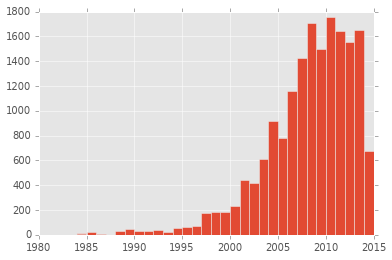

In [11]:
plot_date_data(date_data)

## Release date histogram with dates from albums

First, select the distinct Album-Date data and then plot it.

In [12]:
new_date_data = date_data.drop_duplicates()
new_date_data.describe()

,Date
count,1420.000000
mean,2006.823944
std,4.805152
min,1984.000000
25%,2005.000000
50%,2007.000000
75%,2010.000000
max,2015.000000


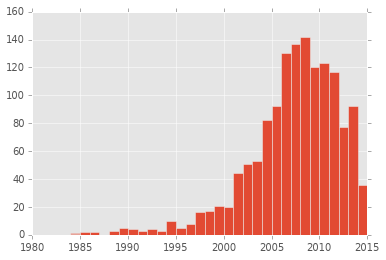

In [13]:
plot_date_data(new_date_data)

# Amount of albums with unknown dates

In [14]:
unknown_dates = new_date_data.assign(DateKnown=~np.isnan(new_date_data["Date"]))\
    [["DateKnown", "Album"]].\
    groupby(["DateKnown"]).\
    count()
unknown_dates

,Album
DateKnown,
False,95
True,1419


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f115ba5c290>], dtype=object)

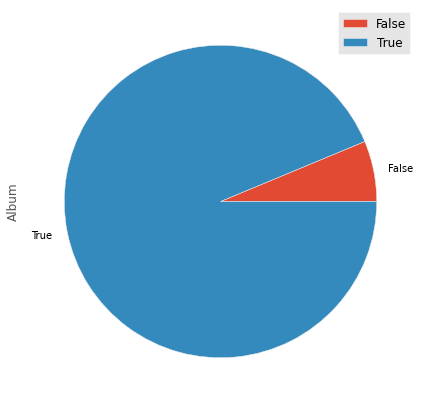

In [15]:
unknown_dates.plot(kind="pie", subplots=True, figsize=(7,7))

# Artist-Album relationships

In [16]:
df[["Artist", "Album"]].drop_duplicates().\
    groupby("Album").count().sort(["Artist"], ascending=False)

-c:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Artist
Album,
Harmony of Heroes,76
Donkey Kong Country 3: Double the Trouble!,63
Final Fantasy VI: Balance and Ruin,59
111 Years of Deutsche Grammophon,59
Varèse Sarabande: A 30th Anniversary Celebration,56
Chiptunes = WIN: Volume 3,51
"Chiptunes = WIN, Volume 2",51
Chiptunes = WIN \m|♥|m/,51
Wild Arms: ARMed and DANGerous,49


In [17]:
art_alb_data = df[["AlbumArtist", "Album"]].drop_duplicates().\
    groupby("AlbumArtist").count()

In [18]:
art_alb_data.sort(["Album"], ascending=False)

-c:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Album
AlbumArtist,
Various Artists,239
OverClocked ReMix,41
Binärpilot,12
Zelda Reorchestrated,12
Disasterpeace,11
The Prodigy,11
John Williams,10
Armin van Buuren,10
Chiptunes = WIN \m|♥|m/,10
